In [1]:
# Standard libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

# For Machine Learning (PyTorch)
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

root = "tensile_fatigue_data_genel_raw.xlsx"
main_df = pd.read_excel(root)

ANN(6, 0.33, 5, 90000, 0.7, 0.9)

In [ ]:
def SNN(h_layer1, h_layer2, h_layer3, graph):
    X = pd.read_excel(root,usecols=[0,1,2,3,4])
    y = pd.read_excel(root,usecols=[6])
    
    # Normalize inputs
    scaler_X = StandardScaler()
    X_scaled = scaler_X.fit_transform(X)
    
    scaler_y = StandardScaler()
    y_scaled = scaler_y.fit_transform(y)
    
    # Convert to PyTorch tensors
    X_tensor = torch.tensor(X_scaled, dtype=torch.float32)
    y_tensor = torch.tensor(y_scaled, dtype=torch.float32)
    
    # Split into train/test
    X_train, X_test, y_train, y_test = train_test_split(X_tensor, y_tensor, test_size = 0.33, random_state = 10)
    
    # Define the neural network
    class DeepNN(nn.Module):
        def __init__(self, input_size = 5, output_size = 1):
            super(DeepNN, self).__init__()
            self.fc1 = nn.Linear(input_size, h_layer1)
            self.fc2 = nn.Linear(h_layer1, h_layer2)
            self.fc3 = nn.Linear(h_layer2, h_layer3)
            self.out = nn.Linear(h_layer3, output_size)
    
            self.activation = nn.Sigmoid()  # Logistic sigmoid
    
        def forward(self, x):
            x = self.activation(self.fc1(x))
            x = self.activation(self.fc2(x))
            x = self.activation(self.fc3(x))
            x = self.out(x)
            return x
    
    # Example instantiation
    model = DeepNN()
    
    # Loss function (Mean Squared Error for regression)
    criterion = nn.MSELoss()
    
    # Optimizer
    optimizer = optim.Adam(model.parameters(), lr = 0.01)
    
    num_epochs = 1000
    mse_train = []
    mse_test  = []

    mape_train = []
    mape_test  = []

    max_r2_test = []
    
    for epoch in range(num_epochs):
        # Forward pass
        outputs = model(X_train)
        y_train_pred = model(X_train)
        y_test_pred = model(X_test)
        loss = criterion(y_train_pred, y_train)

        # Inverse from normalize
        y_train_r = scaler_y.inverse_transform(y_train.detach().numpy())
        y_train_pred_r = scaler_y.inverse_transform(y_train_pred.detach().numpy())
        y_test_r = scaler_y.inverse_transform(y_test.detach().numpy())
        y_test_pred_r = scaler_y.inverse_transform(y_test_pred.detach().numpy())

        # MAPE Calculation
        mape_train_epoch = mean_absolute_percentage_error(y_train_r, y_train_pred_r)*100
        mape_test_epoch = mean_absolute_percentage_error(y_test_r, y_test_pred_r)*100

        mape_train.append(mape_train_epoch)
        mape_test.append(mape_test_epoch)

        # Obtain Minimum MSE
        min_mape_train_x = np.argmin(mape_train)
        min_mape_train_y = np.min(mape_train)
        min_mape_test_x = np.argmin(mape_test)
        min_mape_test_y = np.min(mape_test)

        max_mape_train_y = np.max(mape_train)
        max_mape_test_y = np.max(mape_test)

        var_test  = r2_score(y_test.data.numpy(), y_test_pred.detach().numpy())
        max_r2_test.append(var_test)
        max_r2_test_score = np.max(max_r2_test)
    
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
        var_train = r2_score(y_train.data.numpy(), y_train_pred.detach().numpy())
        var_test  = r2_score(y_test.data.numpy(), y_test_pred.detach().numpy())
    
        if (epoch+1) % 100 == 0 & graph == True:
            print(f"Epoch {epoch+1}/{num_epochs}") #, Training Loss: {loss.item():.4f}
            print("Train R²: ", "%.5f" % round(var_train, 5),"  Train MAPE: ", mape_train_epoch)
            print("Test R² : ", "%.5f" % round(var_test, 5),"  Test MAPE:  ", mape_test_epoch)
            
            fig, axes = plt.subplots(1, 2, figsize = (8,3))
            axes[0].scatter(y_train_r, y_train_pred_r)
            axes[0].plot([min(y_train_r), max(y_train_r)],[min(y_train_r), max(y_train_r)], color = 'r')
            axes[0].set_title("Training Data")
            axes[0].set_xlabel("Actual values")
            axes[0].set_ylabel("Predicted values")
    
            axes[1].scatter(y_test_r, y_test_pred_r)
            axes[1].plot([min(y_test_r), max(y_test_r)],[min(y_test_r), max(y_test_r)], color = 'r')
            axes[1].set_title("Test Data")
            axes[1].set_xlabel("Actual values")
            axes[1].set_ylabel("Predicted values")
            
            f = plt.figure(figsize=(8,5))
            plt.plot(mape_train, label = "Train MAPE")
            plt.plot(mape_test , label = "Test MAPE")
            plt.ylabel("Mean Absolute Percentage Error (%)")
            plt.xlabel("Epoch")
            plt.scatter(min_mape_train_x, min_mape_train_y,c= 'b', label='Minimum MAPE Train')
            plt.scatter(min_mape_test_x, min_mape_test_y,c= 'r', label='Minimum MAPE Test')
            plt.text(epoch * 0.2 , max_mape_train_y * 0.95, f"Train MAPE: {round(min_mape_train_y, 2)}%, Epoch: {min_mape_train_x}", 
                     bbox=dict(boxstyle="square,pad=0.3", fc="lightblue"))
            plt.text(epoch * 0.2 , max_mape_train_y * 0.8, f"Test MAPE: {round(min_mape_test_y, 2)}%, Epoch: {min_mape_test_x}",
                     bbox=dict(boxstyle="square,pad=0.3", fc="orange"))
            plt.legend()
    
            plt.draw();plt.pause(0.05)
        
        plt.ioff()
        plt.show()

    return max_r2_test_score

In [ ]:
test2 = []
test3 = []

for x in range(7, 9,1):
    for y in range(10, 13,1):
        for z in range(16, 19, 1):
            result = SNN(x, y, z, False)
            print("HL 1:", x, "HL 2:", y, "HL 3:", z," Max R2: ", result)
            hlayer_str = f"{x}" + "," + f"{y}" + f"{z}"
            test2.append(result)
            test3.append(hlayer_str)

f = plt.figure(figsize=(16,16))
x_bar = np.array(test3)
y_bar = np.array(test2)

plt.bar(x_bar,y_bar)
plt.xlabel("R2")
plt.ylabel("Number of Hidden Layers")
plt.show()

## Troubleshoot

8, 12 ,16

Epoch 100/1000
Train R²:  0.89265   Train MAPE:  4.71583753824234
Test R² :  0.62639   Test MAPE:   10.888780653476715


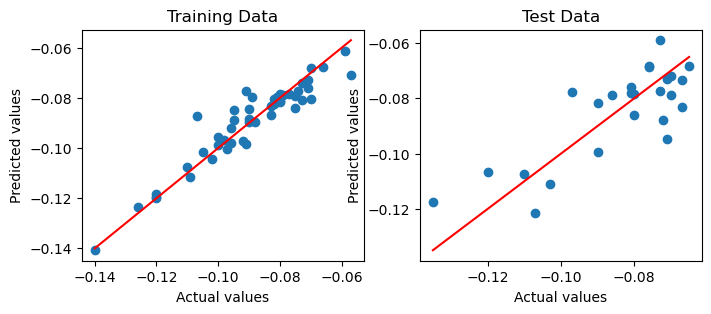

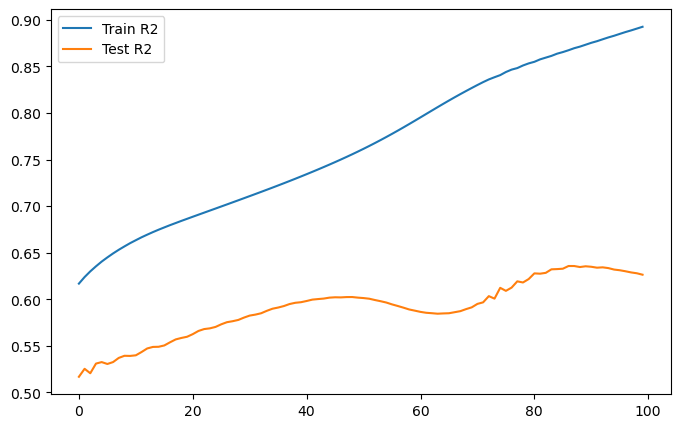

Epoch 200/1000
Train R²:  0.98252   Train MAPE:  1.8372481688857079
Test R² :  0.50896   Test MAPE:   12.752054631710052


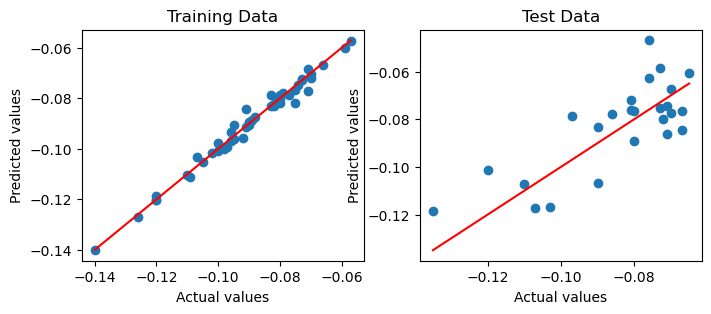

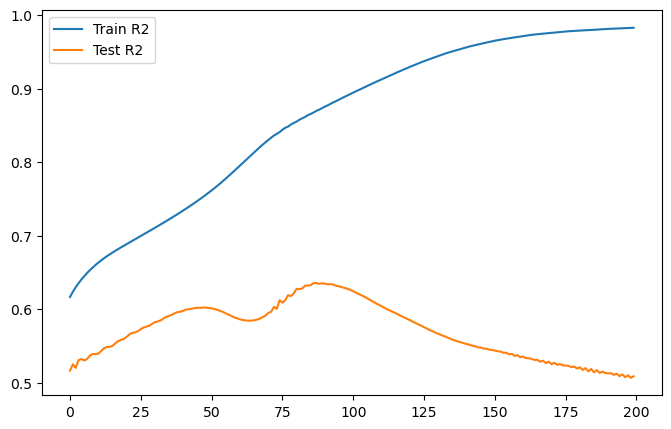

Epoch 300/1000
Train R²:  0.99416   Train MAPE:  1.0797571390867233
Test R² :  0.42268   Test MAPE:   13.306251168251038


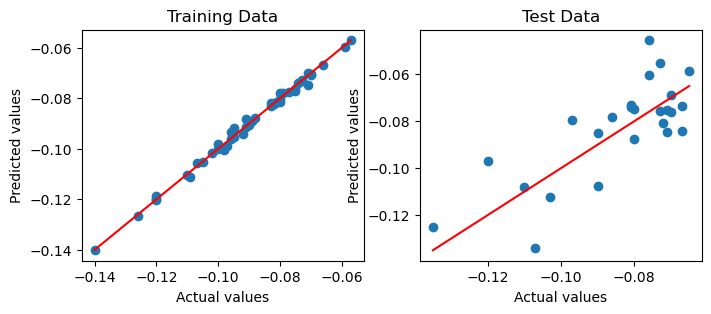

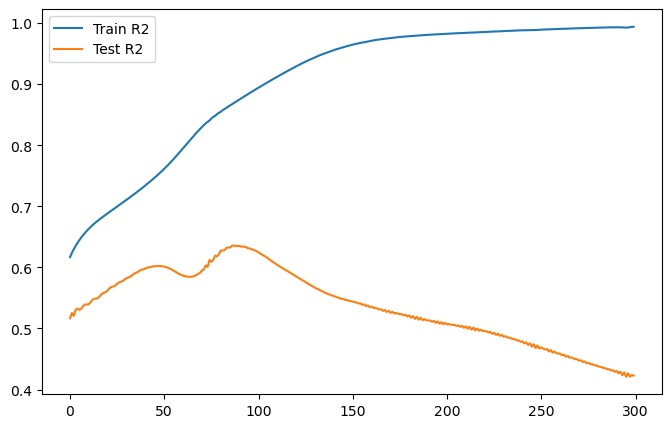

Epoch 400/1000
Train R²:  0.99789   Train MAPE:  0.5859010387212038
Test R² :  0.37779   Test MAPE:   13.156796991825104


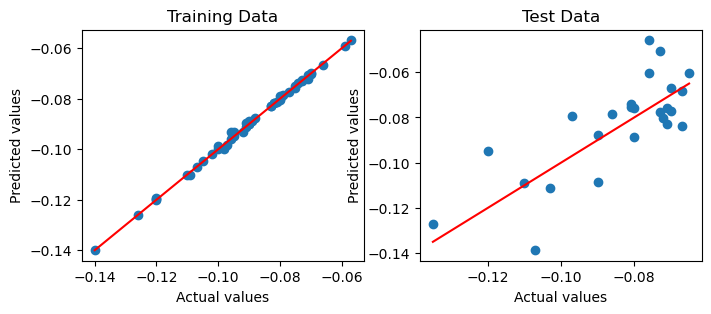

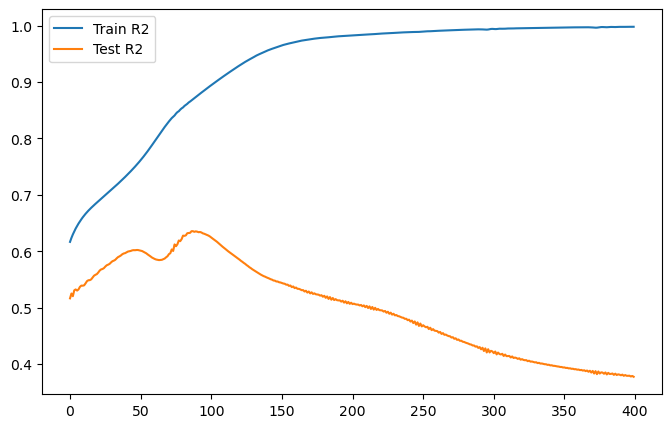

Epoch 500/1000
Train R²:  0.99909   Train MAPE:  0.3306512488052249
Test R² :  0.34507   Test MAPE:   13.262370228767395


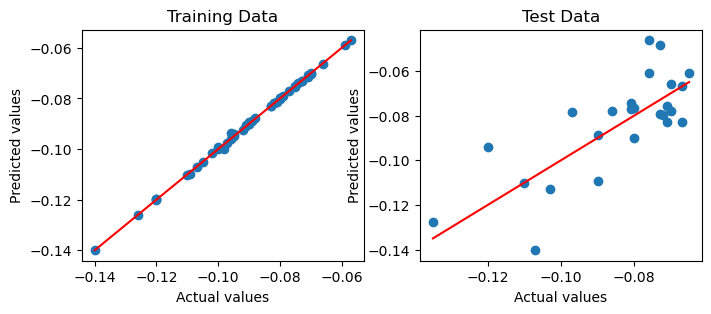

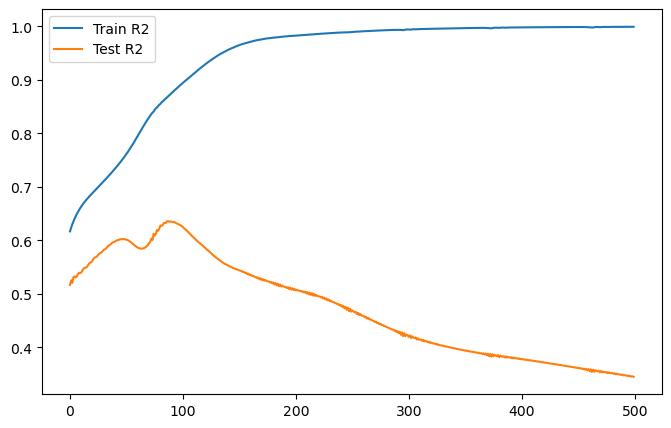

Epoch 600/1000
Train R²:  0.99951   Train MAPE:  0.2549772150814533
Test R² :  0.31180   Test MAPE:   13.576249778270721


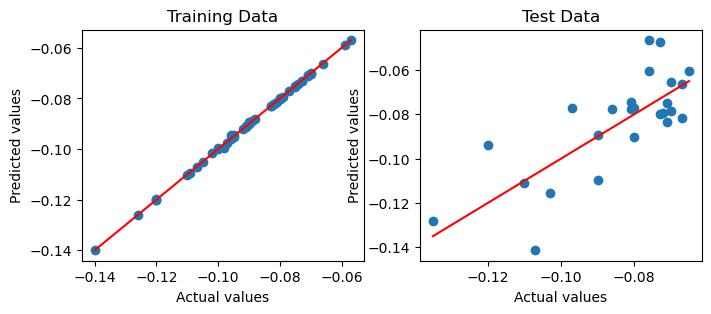

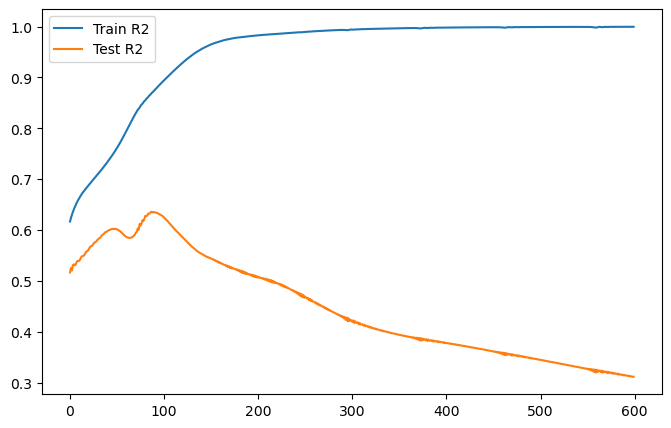

Epoch 700/1000
Train R²:  0.99971   Train MAPE:  0.2093481132760644
Test R² :  0.27949   Test MAPE:   13.879550993442535


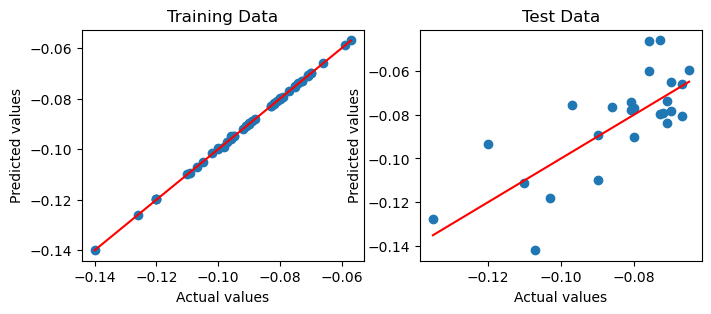

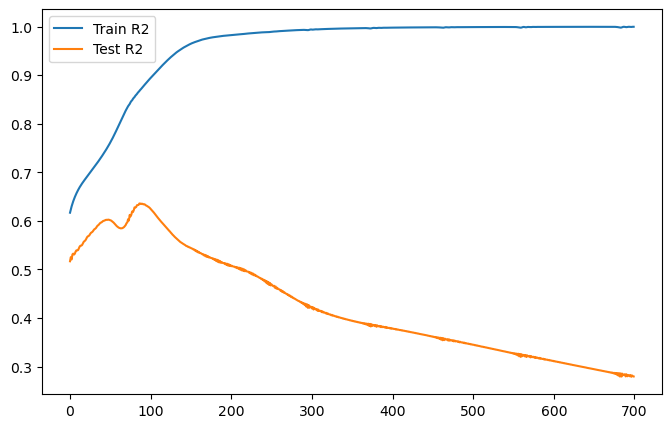

Epoch 800/1000
Train R²:  0.99986   Train MAPE:  0.12024404713883996
Test R² :  0.25187   Test MAPE:   14.081135392189026


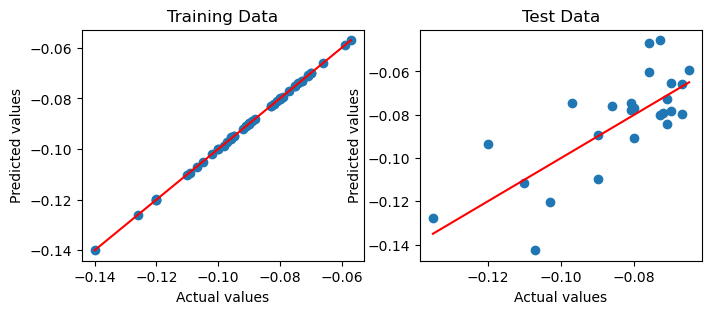

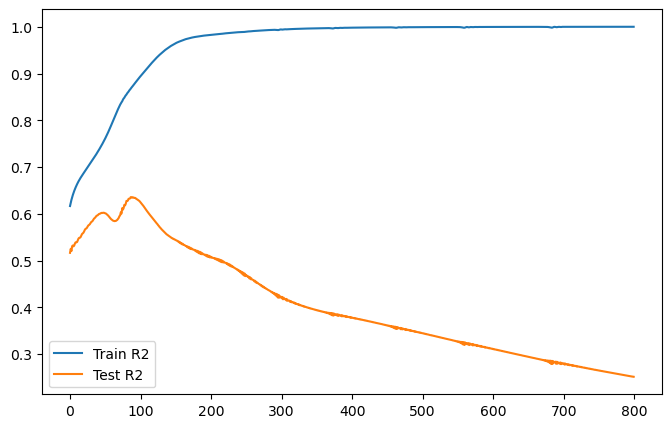

Epoch 900/1000
Train R²:  0.99992   Train MAPE:  0.09055582340806723
Test R² :  0.23043   Test MAPE:   14.23155665397644


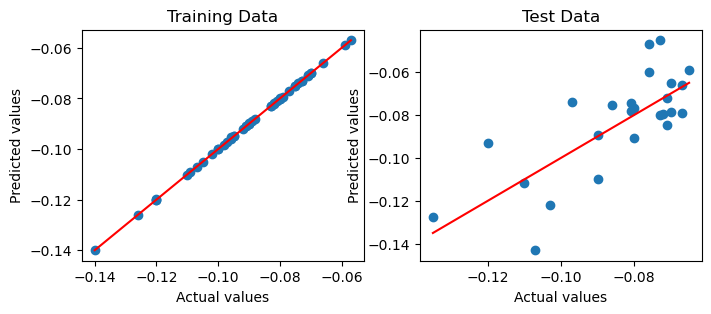

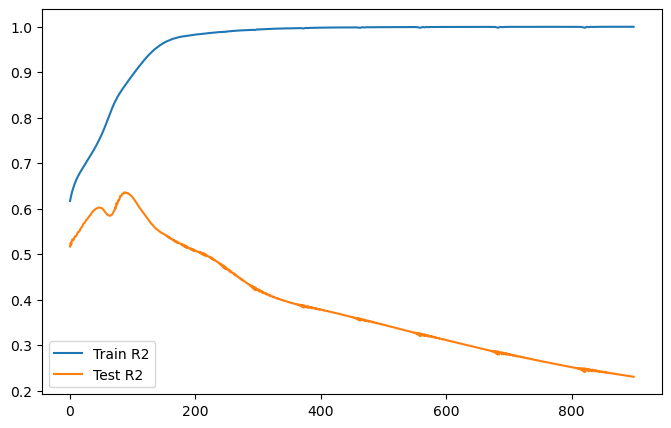

Epoch 1000/1000
Train R²:  0.99964   Train MAPE:  0.35904012620449066
Test R² :  0.21585   Test MAPE:   14.28714394569397


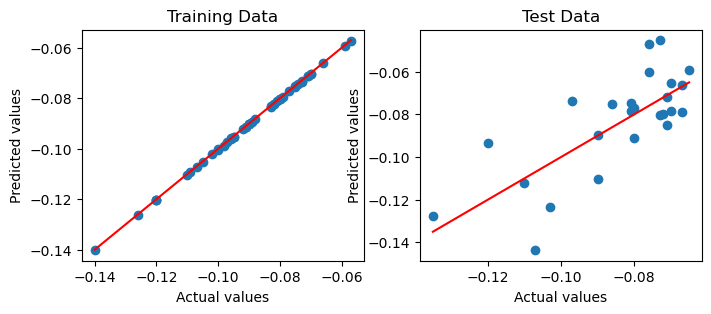

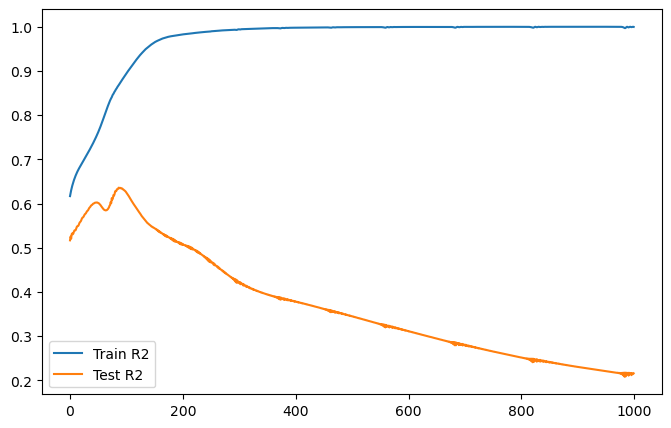

In [16]:
X = pd.read_excel(root,usecols=[0,1,2,3,4])
y = pd.read_excel(root,usecols=[6])

# Normalize inputs
scaler_X = StandardScaler()
X_scaled = scaler_X.fit_transform(X)

scaler_y = StandardScaler()
y_scaled = scaler_y.fit_transform(y)

# Convert to PyTorch tensors
X_tensor = torch.tensor(X_scaled, dtype=torch.float32)
y_tensor = torch.tensor(y_scaled, dtype=torch.float32)

# Split into train/test
X_train, X_test, y_train, y_test = train_test_split(X_tensor, y_tensor, test_size = 0.33, random_state = 10)

# Define the neural network
class DeepNN(nn.Module):
    def __init__(self, input_size = 5, output_size = 1):
        super(DeepNN, self).__init__()
        self.fc1 = nn.Linear(input_size, 8)
        self.fc2 = nn.Linear(8, 12)
        self.fc3 = nn.Linear(12, 16)
        self.out = nn.Linear(16, output_size)

        self.activation = nn.Sigmoid()  # Logistic sigmoid

    def forward(self, x):
        x = self.activation(self.fc1(x))
        x = self.activation(self.fc2(x))
        x = self.activation(self.fc3(x))
        x = self.out(x)
        return x

    def set_manual_weights(self, weights_and_biases):
        with torch.no_grad():
            self.fc1.weight.copy_(torch.tensor(weights_and_biases['fc1_weight'], dtype=torch.float32))
            self.fc1.bias.copy_(torch.tensor(weights_and_biases['fc1_bias'], dtype=torch.float32))
    
            self.fc2.weight.copy_(torch.tensor(weights_and_biases['fc2_weight'], dtype=torch.float32))
            self.fc2.bias.copy_(torch.tensor(weights_and_biases['fc2_bias'], dtype=torch.float32))
    
            self.fc3.weight.copy_(torch.tensor(weights_and_biases['fc3_weight'], dtype=torch.float32))
            self.fc3.bias.copy_(torch.tensor(weights_and_biases['fc3_bias'], dtype=torch.float32))
    
            self.out.weight.copy_(torch.tensor(weights_and_biases['out_weight'], dtype=torch.float32))
            self.out.bias.copy_(torch.tensor(weights_and_biases['out_bias'], dtype=torch.float32))

manual_params = {
    'fc1_weight': fc1_weight,  # shape: (out_features, in_features)
    'fc1_bias': fc1_bias,

    'fc2_weight': fc2_weight,
    'fc2_bias': fc2_bias,

    'fc3_weight': fc3_weight,
    'fc3_bias': fc3_bias,

    'out_weight': out_weight,
    'out_bias': out_bias
}

# Example instantiation
model = DeepNN()
model.set_manual_weights(manual_params)

# Loss function (Mean Squared Error for regression)
criterion = nn.MSELoss()

# Optimizer
optimizer = optim.Adam(model.parameters(), lr = 0.01)

num_epochs = 1000
mse_train = []
mse_test  = []

mape_train = []
mape_test  = []

max_r2_test = []

r2_train = []
r2_test  = []

for epoch in range(num_epochs):
    # Forward pass
    outputs = model(X_train)
    y_train_pred = model(X_train)
    y_test_pred = model(X_test)
    loss = criterion(y_train_pred, y_train)

    # Inverse from normalize
    y_train_r = scaler_y.inverse_transform(y_train.detach().numpy())
    y_train_pred_r = scaler_y.inverse_transform(y_train_pred.detach().numpy())
    y_test_r = scaler_y.inverse_transform(y_test.detach().numpy())
    y_test_pred_r = scaler_y.inverse_transform(y_test_pred.detach().numpy())

    # MAPE Calculation
    mape_train_epoch = mean_absolute_percentage_error(y_train_r, y_train_pred_r)*100
    mape_test_epoch = mean_absolute_percentage_error(y_test_r, y_test_pred_r)*100

    mape_train.append(mape_train_epoch)
    mape_test.append(mape_test_epoch)

    # Obtain Minimum MSE
    min_mape_train_x = np.argmin(mape_train)
    min_mape_train_y = np.min(mape_train)
    min_mape_test_x = np.argmin(mape_test)
    min_mape_test_y = np.min(mape_test)

    max_mape_train_y = np.max(mape_train)
    max_mape_test_y = np.max(mape_test)

    var_train = r2_score(y_train.data.numpy(), y_train_pred.detach().numpy())
    var_test  = r2_score(y_test.data.numpy(), y_test_pred.detach().numpy())
    r2_train.append(var_train)
    r2_test.append(var_test)
    max_r2_test_score = np.max(r2_test)

    # Backward and optimize
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if (epoch+1) % 100 == 0:
        print(f"Epoch {epoch+1}/{num_epochs}") #, Training Loss: {loss.item():.4f}
        print("Train R²: ", "%.5f" % round(var_train, 5),"  Train MAPE: ", mape_train_epoch)
        print("Test R² : ", "%.5f" % round(var_test, 5),"  Test MAPE:  ", mape_test_epoch)
        
        fig, axes = plt.subplots(1, 2, figsize = (8,3))
        axes[0].scatter(y_train_r, y_train_pred_r)
        axes[0].plot([min(y_train_r), max(y_train_r)],[min(y_train_r), max(y_train_r)], color = 'r')
        axes[0].set_title("Training Data")
        axes[0].set_xlabel("Actual values")
        axes[0].set_ylabel("Predicted values")

        axes[1].scatter(y_test_r, y_test_pred_r)
        axes[1].plot([min(y_test_r), max(y_test_r)],[min(y_test_r), max(y_test_r)], color = 'r')
        axes[1].set_title("Test Data")
        axes[1].set_xlabel("Actual values")
        axes[1].set_ylabel("Predicted values")
        
        f = plt.figure(figsize=(8,5))
        plt.plot(r2_train, label = "Train R2")
        plt.plot(r2_test,  label = "Test R2")
        plt.legend()

        plt.draw();plt.pause(0.05)
    
    plt.ioff()
    plt.show()

In [13]:
x = np.random.rand(3,2)
print(x)

[[0.97033618 0.12996668]
 [0.79364347 0.47425488]
 [0.06991653 0.55006594]]


In [14]:
fc1_weight = [[ 1.3280,  3.9301, -0.9248,  2.2740,  0.2188],
        [ 1.5080,  3.3409,  0.1286,  2.7757,  1.0977],
        [-2.3500,  2.6643,  1.2387,  1.2238,  1.3000],
        [ 0.6007,  5.5967, -5.5611, -1.4889, -1.5426],
        [ 1.5594,  2.6302,  1.2694,  2.8569,  0.9612],
        [ 1.1531,  1.9638,  1.4017, -1.5991,  1.8921],
        [-2.6871,  1.5272,  0.4369, -3.2589, -1.4125],
        [-1.2941,  2.4301,  0.7704,  0.9021,  0.7327]]

fc1_bias = [ 0.0603, -0.3398,  0.1509, -1.4655, -0.5470, -0.3734,  1.4607,  0.4744]

fc2_weight = [[-0.7758, -1.1554, -0.1671, -1.1167, -1.0997,  0.9837, -0.4450,  0.1275],
        [ 0.0110, -0.0275, -0.0826, -1.2612, -0.0229, -0.8477,  0.2486, -0.6656],
        [-0.4505, -1.0436, -1.6755, -3.6536, -0.3577,  0.8403, -2.1315, -0.5771],
        [-1.3313, -0.5380, -0.0310, -1.6429, -1.0809,  0.8501, -0.6329, -0.4237],
        [-0.5681, -1.0993,  0.0683, -1.7850, -1.0169,  0.7652, -0.7394, -0.6923],
        [-0.8657, -1.4970, -1.7001, -3.9898, -0.9835,  2.3012, -2.5014, -0.7184],
        [-0.6668, -1.1839, -1.4142, -2.8094, -0.6886,  0.3208, -1.2000, -0.4465],
        [-1.0239, -0.1988, -0.2493, -1.5112, -0.6254, -0.2754, -0.5909, -0.4186],
        [-1.4160, -1.3761, -0.7514, -3.2214, -1.0733,  1.6196, -1.9483, -0.0788],
        [-1.0720, -0.9168, -0.4172, -0.7098, -0.5977, -0.1094,  0.5587,  0.1321],
        [-1.3721, -1.3689,  1.4572, -2.4774,  0.1715,  2.7094,  0.6365,  1.5308],
        [-1.1873, -0.6647, -0.7661, -2.9747, -0.3448,  0.6726, -1.6098, -1.0999]]

fc2_bias = [-0.2155,  0.3128,  1.0512, -0.0095,  0.0982,  1.6569,  0.4112, -0.2858,
         1.1394, -0.1838,  0.3872,  0.7276]

fc3_weight = [[-2.2864e-01, -1.4523e-01, -6.6473e-01, -2.4671e-01, -4.5452e-01,
         -5.1818e-01,  2.9899e-02, -4.9422e-02, -2.0969e-01, -2.7521e-01,
         -3.7760e-01, -4.1691e-01],
        [ 5.8165e-01, -3.5030e-01,  1.6717e-02,  2.5865e-01,  3.4920e-01,
          9.3878e-01,  8.3860e-01,  2.7018e-01,  4.0041e-01,  3.4777e-01,
          8.6500e-01,  9.5973e-02],
        [-2.4821e-02, -4.9941e-01, -5.1353e-01, -2.1878e-01, -4.0041e-01,
         -3.6380e-02, -3.7884e-01, -3.2708e-01, -2.9514e-01, -4.3779e-01,
         -2.9098e-02,  6.5024e-02],
        [ 7.5518e-02, -4.2357e-01,  1.0058e-01, -3.9984e-01,  4.5744e-02,
         -8.2683e-01, -6.1433e-01, -5.7403e-02, -7.5472e-01, -1.5895e-01,
         -8.1009e-01, -5.7779e-01],
        [ 7.1105e-01, -8.2537e-01,  1.1877e+00,  6.5091e-01,  1.1900e+00,
          1.7692e+00,  8.5940e-01,  2.8840e-01,  1.3352e+00,  4.2612e-01,
          9.6452e-01,  1.0171e+00],
        [-5.8945e-01, -2.4406e-01, -4.6065e-01, -1.0969e-01, -3.1006e-01,
         -4.7203e-01, -1.3702e-01,  9.7357e-03, -8.8993e-01, -9.6209e-02,
         -2.8394e-01, -6.5182e-01],
        [ 6.6560e-03,  7.4962e-02, -3.5846e-01,  7.8153e-02, -3.3933e-02,
         -7.7527e-01, -5.1221e-01, -2.2761e-01, -7.4761e-01, -2.8780e-01,
         -6.6619e-01, -4.0689e-01],
        [-2.7328e-01, -3.2132e-02, -2.1645e-01, -4.8635e-01, -7.7795e-01,
         -5.0388e-01, -5.6934e-01, -3.3405e-01, -2.1141e-01, -7.7165e-01,
         -6.7544e-01, -9.6522e-02],
        [-1.4954e-01, -3.0929e-01,  5.0576e-01,  3.4068e-01,  7.3533e-01,
          3.9787e-01, -6.0180e-02, -1.9519e-01,  9.3984e-01, -5.9076e-03,
          1.2517e-01,  6.6744e-01],
        [-9.3543e-01,  2.4223e-01, -5.4166e-01, -4.4884e-01, -1.1653e-01,
         -3.9455e-01, -3.3707e-01, -6.6346e-01, -1.0280e+00, -4.9591e-01,
         -4.3308e-01, -6.8676e-01],
        [-1.5036e-02, -3.4392e-01, -1.0683e-01, -2.9481e-01,  6.3353e-02,
         -4.4676e-01, -6.5101e-01, -3.7417e-01, -3.0553e-01,  1.3334e-01,
         -2.4258e-01, -2.2438e-01],
        [ 1.0603e+00, -1.6542e+00,  3.6981e+00,  1.0162e+00,  1.5027e+00,
          5.5888e+00,  2.0510e+00, -2.8781e-01,  4.3018e+00, -2.6686e+00,
          2.5329e-01,  3.7588e+00],
        [-5.5351e-01,  1.3488e-02, -3.7850e-01, -3.7361e-01, -5.3968e-02,
         -9.1059e-01, -3.9543e-01, -4.5033e-02, -6.9572e-03, -4.2798e-01,
         -6.3337e-01, -8.7320e-02],
        [-6.5376e-03, -1.9544e-01, -8.0495e-01, -3.0763e-01, -2.2200e-01,
         -9.4425e-01, -7.4494e-02, -1.2479e-01, -2.5487e-01, -3.5225e-01,
         -4.9329e-01, -1.1839e-01],
        [-3.3510e-01,  3.7754e-01, -2.5952e-01, -2.1260e-01, -3.6621e-01,
         -1.8215e-01, -6.6536e-02, -4.3896e-01, -3.9782e-01,  5.2288e-01,
         -3.3496e-01, -3.8624e-01],
        [-1.1039e-01,  2.5490e-01, -4.3182e-01, -7.0558e-01, -1.8593e-01,
         -1.0566e+00, -1.0058e+00, -3.7953e-01, -1.1101e+00,  3.8423e-03,
         -3.5190e-01, -7.0030e-01]]

fc3_bias = [ 0.0801,  0.2949, -0.0743,  0.1411, -2.4409, -0.0688,  0.0999,  0.0626,
         0.5405,  0.1799, -0.5455, -5.3611, -0.3883, -0.2745, -0.3252,  0.5183]

out_weight = [[ 0.0897, -0.1898,  0.0680,  0.2533, -0.5805,  0.2861,  0.1660,  0.2454,
         -0.1838,  0.5024,  0.1369, -0.6571,  0.2257,  0.4521,  0.0471,  0.4928]]

out_bias = [-0.2759]

In [11]:
for name, param in model.named_parameters():
    if param.requires_grad:
        print (name, param.data)

fc1.weight tensor([[ 1.3280,  3.9301, -0.9248,  2.2740,  0.2188],
        [ 1.5080,  3.3409,  0.1286,  2.7757,  1.0977],
        [-2.3500,  2.6643,  1.2387,  1.2238,  1.3000],
        [ 0.6007,  5.5967, -5.5611, -1.4889, -1.5426],
        [ 1.5594,  2.6302,  1.2694,  2.8569,  0.9612],
        [ 1.1531,  1.9638,  1.4017, -1.5991,  1.8921],
        [-2.6871,  1.5272,  0.4369, -3.2589, -1.4125],
        [-1.2941,  2.4301,  0.7704,  0.9021,  0.7327]])
fc1.bias tensor([ 0.0603, -0.3398,  0.1509, -1.4655, -0.5470, -0.3734,  1.4607,  0.4744])
fc2.weight tensor([[-0.7758, -1.1554, -0.1671, -1.1167, -1.0997,  0.9837, -0.4450,  0.1275],
        [ 0.0110, -0.0275, -0.0826, -1.2612, -0.0229, -0.8477,  0.2486, -0.6656],
        [-0.4505, -1.0436, -1.6755, -3.6536, -0.3577,  0.8403, -2.1315, -0.5771],
        [-1.3313, -0.5380, -0.0310, -1.6429, -1.0809,  0.8501, -0.6329, -0.4237],
        [-0.5681, -1.0993,  0.0683, -1.7850, -1.0169,  0.7652, -0.7394, -0.6923],
        [-0.8657, -1.4970, -1.7001, -

In [ ]:
test4 = []
test5 = []

for x in range(6, 10,1):
    for y in range(9, 13,1):
        for z in range(14, 20, 1):
            result = SNN_ReLU(x, y, z, False)
            print("HL 1:", x, "HL 2:", y, "HL 3:", z," Max R2: ", result)
            hlayer_str = f"{x}" + "," + f"{y}" + f"{z}"
            test4.append(result)
            test5.append(hlayer_str)

f = plt.figure(figsize=(16,16))
x_bar = np.array(test4)
y_bar = np.array(test5)

plt.bar(x_bar,y_bar)
plt.xlabel("R2")
plt.ylabel("Number of Hidden Layers")
plt.show()

In [ ]:
X = pd.read_excel(root,usecols=[0,1,2,3,4])
y = pd.read_excel(root,usecols=[6])

# Normalize inputs
scaler_X = StandardScaler()
X_scaled = scaler_X.fit_transform(X)

scaler_y = StandardScaler()
y_scaled = scaler_y.fit_transform(y)

# Convert to PyTorch tensors
X_tensor = torch.tensor(X_scaled, dtype=torch.float32)
y_tensor = torch.tensor(y_scaled, dtype=torch.float32)

# Split into train/test
X_train, X_test, y_train, y_test = train_test_split(X_tensor, y_tensor, test_size = 0.33, random_state = 10)

# Define the neural network
class DeepNN(nn.Module):
    def __init__(self, input_size = 5, output_size = 1):
        super(DeepNN, self).__init__()
        self.fc1 = nn.Linear(input_size, 8)
        self.fc2 = nn.Linear(8, 12)
        self.fc3 = nn.Linear(12, 16)
        self.out = nn.Linear(16, output_size)

        self.activation = nn.ReLU()  # Logistic sigmoid

    def forward(self, x):
        x = self.activation(self.fc1(x))
        x = self.activation(self.fc2(x))
        x = self.activation(self.fc3(x))
        x = self.out(x)
        return x

# Example instantiation
model = DeepNN()

# Loss function (Mean Squared Error for regression)
criterion = nn.MSELoss()

# Optimizer
optimizer = optim.Adam(model.parameters(), lr = 0.01)

num_epochs = 1000
mse_train = []
mse_test  = []

mape_train = []
mape_test  = []

max_r2_test = []

r2_train = []
r2_test  = []

for epoch in range(num_epochs):
    # Forward pass
    outputs = model(X_train)
    y_train_pred = model(X_train)
    y_test_pred = model(X_test)
    loss = criterion(y_train_pred, y_train)

    # Inverse from normalize
    y_train_r = scaler_y.inverse_transform(y_train.detach().numpy())
    y_train_pred_r = scaler_y.inverse_transform(y_train_pred.detach().numpy())
    y_test_r = scaler_y.inverse_transform(y_test.detach().numpy())
    y_test_pred_r = scaler_y.inverse_transform(y_test_pred.detach().numpy())

    # MAPE Calculation
    mape_train_epoch = mean_absolute_percentage_error(y_train_r, y_train_pred_r)*100
    mape_test_epoch = mean_absolute_percentage_error(y_test_r, y_test_pred_r)*100

    mape_train.append(mape_train_epoch)
    mape_test.append(mape_test_epoch)

    # Obtain Minimum MSE
    min_mape_train_x = np.argmin(mape_train)
    min_mape_train_y = np.min(mape_train)
    min_mape_test_x = np.argmin(mape_test)
    min_mape_test_y = np.min(mape_test)

    max_mape_train_y = np.max(mape_train)
    max_mape_test_y = np.max(mape_test)

    var_train = r2_score(y_train.data.numpy(), y_train_pred.detach().numpy())
    var_test  = r2_score(y_test.data.numpy(), y_test_pred.detach().numpy())
    r2_train.append(var_train)
    r2_test.append(var_test)
    max_r2_test_score = np.max(r2_test)

    # Backward and optimize
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if (epoch+1) % 100 == 0:
        print(f"Epoch {epoch+1}/{num_epochs}") #, Training Loss: {loss.item():.4f}
        print("Train R²: ", "%.5f" % round(var_train, 5),"  Train MAPE: ", mape_train_epoch)
        print("Test R² : ", "%.5f" % round(var_test, 5),"  Test MAPE:  ", mape_test_epoch)
        
        fig, axes = plt.subplots(1, 2, figsize = (8,3))
        axes[0].scatter(y_train_r, y_train_pred_r)
        axes[0].plot([min(y_train_r), max(y_train_r)],[min(y_train_r), max(y_train_r)], color = 'r')
        axes[0].set_title("Training Data")
        axes[0].set_xlabel("Actual values")
        axes[0].set_ylabel("Predicted values")

        axes[1].scatter(y_test_r, y_test_pred_r)
        axes[1].plot([min(y_test_r), max(y_test_r)],[min(y_test_r), max(y_test_r)], color = 'r')
        axes[1].set_title("Test Data")
        axes[1].set_xlabel("Actual values")
        axes[1].set_ylabel("Predicted values")
        
        f = plt.figure(figsize=(8,5))
        plt.plot(r2_train, label = "Train R2")
        plt.plot(r2_test,  label = "Test R2")
        # plt.plot(mape_train, label = "Train MAPE")
        # plt.plot(mape_test , label = "Test MAPE")
        # plt.ylabel("Mean Absolute Percentage Error (%)")
        # plt.xlabel("Epoch")
        # plt.scatter(min_mape_train_x, min_mape_train_y,c= 'b', label='Minimum MAPE Train')
        # plt.scatter(min_mape_test_x, min_mape_test_y,c= 'r', label='Minimum MAPE Test')
        # plt.text(epoch * 0.2 , max_mape_train_y * 0.95, f"Train MAPE: {round(min_mape_train_y, 2)}%, Epoch: {min_mape_train_x}", 
        #          bbox=dict(boxstyle="square,pad=0.3", fc="lightblue"))
        # plt.text(epoch * 0.2 , max_mape_train_y * 0.8, f"Test MAPE: {round(min_mape_test_y, 2)}%, Epoch: {min_mape_test_x}",
        #          bbox=dict(boxstyle="square,pad=0.3", fc="orange"))
        plt.legend()

        plt.draw();plt.pause(0.05)
    
    plt.ioff()
    plt.show()

## Repeatability Test

### Fixed Weights & Bias

In [27]:
def Repeat(graph):
    X = pd.read_excel(root,usecols=[0,1,2,3,4])
    y = pd.read_excel(root,usecols=[6])
    
    # Normalize inputs
    scaler_X = StandardScaler()
    X_scaled = scaler_X.fit_transform(X)
    
    scaler_y = StandardScaler()
    y_scaled = scaler_y.fit_transform(y)
    
    # Convert to PyTorch tensors
    X_tensor = torch.tensor(X_scaled, dtype=torch.float32)
    y_tensor = torch.tensor(y_scaled, dtype=torch.float32)
    
    # Split into train/test
    X_train, X_test, y_train, y_test = train_test_split(X_tensor, y_tensor, test_size = 0.33, random_state = 10)
    
    # Define the neural network
    class DeepNN(nn.Module):
        def __init__(self, input_size = 5, output_size = 1):
            super(DeepNN, self).__init__()
            self.fc1 = nn.Linear(input_size, 8)
            self.fc2 = nn.Linear(8, 12)
            self.fc3 = nn.Linear(12, 16)
            self.out = nn.Linear(16, output_size)
    
            self.activation = nn.Sigmoid()  # Logistic sigmoid
    
        def forward(self, x):
            x = self.activation(self.fc1(x))
            x = self.activation(self.fc2(x))
            x = self.activation(self.fc3(x))
            x = self.out(x)
            return x
    
        def set_manual_weights(self, weights_and_biases):
            with torch.no_grad():
                self.fc1.weight.copy_(torch.tensor(weights_and_biases['fc1_weight'], dtype=torch.float32))
                self.fc1.bias.copy_(torch.tensor(weights_and_biases['fc1_bias'], dtype=torch.float32))
        
                self.fc2.weight.copy_(torch.tensor(weights_and_biases['fc2_weight'], dtype=torch.float32))
                self.fc2.bias.copy_(torch.tensor(weights_and_biases['fc2_bias'], dtype=torch.float32))
        
                self.fc3.weight.copy_(torch.tensor(weights_and_biases['fc3_weight'], dtype=torch.float32))
                self.fc3.bias.copy_(torch.tensor(weights_and_biases['fc3_bias'], dtype=torch.float32))
        
                self.out.weight.copy_(torch.tensor(weights_and_biases['out_weight'], dtype=torch.float32))
                self.out.bias.copy_(torch.tensor(weights_and_biases['out_bias'], dtype=torch.float32))
    
    manual_params = {
        'fc1_weight': fc1_weight,  # shape: (out_features, in_features)
        'fc1_bias': fc1_bias,
    
        'fc2_weight': fc2_weight,
        'fc2_bias': fc2_bias,
    
        'fc3_weight': fc3_weight,
        'fc3_bias': fc3_bias,
    
        'out_weight': out_weight,
        'out_bias': out_bias
    }
    
    # Example instantiation
    model = DeepNN()
    model.set_manual_weights(manual_params)
    
    # Loss function (Mean Squared Error for regression)
    criterion = nn.MSELoss()
    
    # Optimizer
    optimizer = optim.Adam(model.parameters(), lr = 0.01)
    
    num_epochs = 1000
    mse_train = []
    mse_test  = []
    
    mape_train = []
    mape_test  = []
    
    max_r2_test = []
    
    r2_train = []
    r2_test  = []
    
    for epoch in range(num_epochs):
        # Forward pass
        outputs = model(X_train)
        y_train_pred = model(X_train)
        y_test_pred = model(X_test)
        loss = criterion(y_train_pred, y_train)
    
        # Inverse from normalize
        y_train_r = scaler_y.inverse_transform(y_train.detach().numpy())
        y_train_pred_r = scaler_y.inverse_transform(y_train_pred.detach().numpy())
        y_test_r = scaler_y.inverse_transform(y_test.detach().numpy())
        y_test_pred_r = scaler_y.inverse_transform(y_test_pred.detach().numpy())
    
        # MAPE Calculation
        mape_train_epoch = mean_absolute_percentage_error(y_train_r, y_train_pred_r)*100
        mape_test_epoch = mean_absolute_percentage_error(y_test_r, y_test_pred_r)*100
    
        mape_train.append(mape_train_epoch)
        mape_test.append(mape_test_epoch)
    
        # Obtain Minimum MSE
        min_mape_train_x = np.argmin(mape_train)
        min_mape_train_y = np.min(mape_train)
        min_mape_test_x = np.argmin(mape_test)
        min_mape_test_y = np.min(mape_test)
    
        max_mape_train_y = np.max(mape_train)
        max_mape_test_y = np.max(mape_test)
    
        var_train = r2_score(y_train.data.numpy(), y_train_pred.detach().numpy())
        var_test  = r2_score(y_test.data.numpy(), y_test_pred.detach().numpy())
        r2_train.append(var_train)
        r2_test.append(var_test)
        max_r2_test_score = np.max(r2_test)
    
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
        if (epoch+1) % 100 == 0 & graph == True:
            print(f"Epoch {epoch+1}/{num_epochs}") #, Training Loss: {loss.item():.4f}
            print("Train R²: ", "%.5f" % round(var_train, 5),"  Train MAPE: ", mape_train_epoch)
            print("Test R² : ", "%.5f" % round(var_test, 5),"  Test MAPE:  ", mape_test_epoch)
            
            fig, axes = plt.subplots(1, 2, figsize = (8,3))
            axes[0].scatter(y_train_r, y_train_pred_r)
            axes[0].plot([min(y_train_r), max(y_train_r)],[min(y_train_r), max(y_train_r)], color = 'r')
            axes[0].set_title("Training Data")
            axes[0].set_xlabel("Actual values")
            axes[0].set_ylabel("Predicted values")
    
            axes[1].scatter(y_test_r, y_test_pred_r)
            axes[1].plot([min(y_test_r), max(y_test_r)],[min(y_test_r), max(y_test_r)], color = 'r')
            axes[1].set_title("Test Data")
            axes[1].set_xlabel("Actual values")
            axes[1].set_ylabel("Predicted values")
            
            f = plt.figure(figsize=(8,5))
            plt.plot(r2_train, label = "Train R2")
            plt.plot(r2_test,  label = "Test R2")
            plt.legend()
    
            plt.draw();plt.pause(0.05)
        
        plt.ioff()
        plt.show()

    return max_r2_test_score

0.6357315236647615
0.6357315236647615
0.6357315236647615
0.6357315236647615
0.6357315236647615
0.6357315236647615
0.6357315236647615
0.6357315236647615
0.6357315236647615
0.6357315236647615


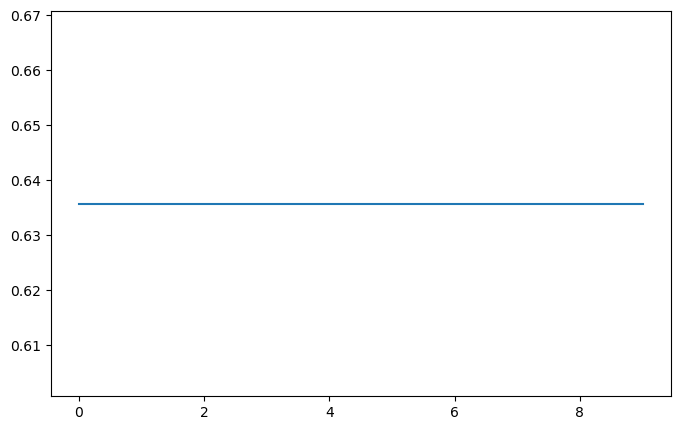

In [29]:
test_x = []

for x in range(10):
    res = Repeat(False)
    print(res)
    test_x.append(res)

f = plt.figure(figsize=(8,5))
plt.plot(test_x)
plt.show()

### Randomize Weights & Bias

In [3]:
def Repeat2(graph):
    X = pd.read_excel(root,usecols=[0,1,2,3,4])
    y = pd.read_excel(root,usecols=[6])
    
    # Normalize inputs
    scaler_X = StandardScaler()
    X_scaled = scaler_X.fit_transform(X)
    
    scaler_y = StandardScaler()
    y_scaled = scaler_y.fit_transform(y)
    
    # Convert to PyTorch tensors
    X_tensor = torch.tensor(X_scaled, dtype=torch.float32)
    y_tensor = torch.tensor(y_scaled, dtype=torch.float32)
    
    # Split into train/test
    X_train, X_test, y_train, y_test = train_test_split(X_tensor, y_tensor, test_size = 0.33, random_state = 10)
    
    # Define the neural network
    class DeepNN(nn.Module):
        def __init__(self, input_size = 5, output_size = 1):
            super(DeepNN, self).__init__()
            self.fc1 = nn.Linear(input_size, 8)
            self.fc2 = nn.Linear(8, 12)
            self.fc3 = nn.Linear(12, 16)
            self.out = nn.Linear(16, output_size)
    
            self.activation = nn.Sigmoid()  # Logistic sigmoid
    
        def forward(self, x):
            x = self.activation(self.fc1(x))
            x = self.activation(self.fc2(x))
            x = self.activation(self.fc3(x))
            x = self.out(x)
            return x
    
    # Example instantiation
    model = DeepNN()
    
    # Loss function (Mean Squared Error for regression)
    criterion = nn.MSELoss()
    
    # Optimizer
    optimizer = optim.Adam(model.parameters(), lr = 0.01)
    
    num_epochs = 1000
    mse_train = []
    mse_test  = []
    
    mape_train = []
    mape_test  = []
    
    max_r2_test = []
    
    r2_train = []
    r2_test  = []
    
    for epoch in range(num_epochs):
        # Forward pass
        outputs = model(X_train)
        y_train_pred = model(X_train)
        y_test_pred = model(X_test)
        loss = criterion(y_train_pred, y_train)
    
        # Inverse from normalize
        y_train_r = scaler_y.inverse_transform(y_train.detach().numpy())
        y_train_pred_r = scaler_y.inverse_transform(y_train_pred.detach().numpy())
        y_test_r = scaler_y.inverse_transform(y_test.detach().numpy())
        y_test_pred_r = scaler_y.inverse_transform(y_test_pred.detach().numpy())
    
        # MAPE Calculation
        mape_train_epoch = mean_absolute_percentage_error(y_train_r, y_train_pred_r)*100
        mape_test_epoch = mean_absolute_percentage_error(y_test_r, y_test_pred_r)*100
    
        mape_train.append(mape_train_epoch)
        mape_test.append(mape_test_epoch)
    
        # Obtain Minimum MSE
        min_mape_train_x = np.argmin(mape_train)
        min_mape_train_y = np.min(mape_train)
        min_mape_test_x = np.argmin(mape_test)
        min_mape_test_y = np.min(mape_test)
    
        max_mape_train_y = np.max(mape_train)
        max_mape_test_y = np.max(mape_test)
    
        var_train = r2_score(y_train.data.numpy(), y_train_pred.detach().numpy())
        var_test  = r2_score(y_test.data.numpy(), y_test_pred.detach().numpy())
        r2_train.append(var_train)
        r2_test.append(var_test)
        max_r2_test_score = np.max(r2_test)
    
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
        if (epoch+1) % 100 == 0 & graph == True:
            print(f"Epoch {epoch+1}/{num_epochs}") #, Training Loss: {loss.item():.4f}
            print("Train R²: ", "%.5f" % round(var_train, 5),"  Train MAPE: ", mape_train_epoch)
            print("Test R² : ", "%.5f" % round(var_test, 5),"  Test MAPE:  ", mape_test_epoch)
            
            fig, axes = plt.subplots(1, 2, figsize = (8,3))
            axes[0].scatter(y_train_r, y_train_pred_r)
            axes[0].plot([min(y_train_r), max(y_train_r)],[min(y_train_r), max(y_train_r)], color = 'r')
            axes[0].set_title("Training Data")
            axes[0].set_xlabel("Actual values")
            axes[0].set_ylabel("Predicted values")
    
            axes[1].scatter(y_test_r, y_test_pred_r)
            axes[1].plot([min(y_test_r), max(y_test_r)],[min(y_test_r), max(y_test_r)], color = 'r')
            axes[1].set_title("Test Data")
            axes[1].set_xlabel("Actual values")
            axes[1].set_ylabel("Predicted values")
            
            f = plt.figure(figsize=(8,5))
            plt.plot(r2_train, label = "Train R2")
            plt.plot(r2_test,  label = "Test R2")
            plt.legend()
    
            plt.draw();plt.pause(0.05)
        
        plt.ioff()
        plt.show()
    return max_r2_test_score

0.4652563044180329
0.5542869619020845
0.5343274058006311
0.6661609436803293
0.5368156628425191
0.6457326715680941
0.3775128371824913
0.6652920575810766
0.5024338683487211
0.4385373206903227
0.5155820177040182
0.5588902732262988
0.5057110081578831
0.5178762032969764
0.7813880839298241
0.5449015645635689
0.5043718101701726
0.5285537744976923
0.49426530622609555
0.6846351189004237
0.6728021513370748
0.5695374224009307
0.5853416912866061
0.5196359101556145
0.3892015472203151
0.5199932133916001
0.45721032520960136
0.5040486261115145
0.4847161256367697
0.44846889075134355
0.44592474825944173
0.5771676805184373
0.7092987661248005
0.5101333165310674
0.5829969266106824
0.4671691785318536
0.6245785781395666
0.45374348969511424
0.639726264205108
0.6262313452522519
0.47093545706367346
0.5324399298919573
0.6173124661544529
0.5532568054506817
0.6643137216367803
0.45399619625499177
0.4378078449694818
0.6862122511607571
0.4692069376852993
0.3719827513038786
Average R2: 0.5413584350725781


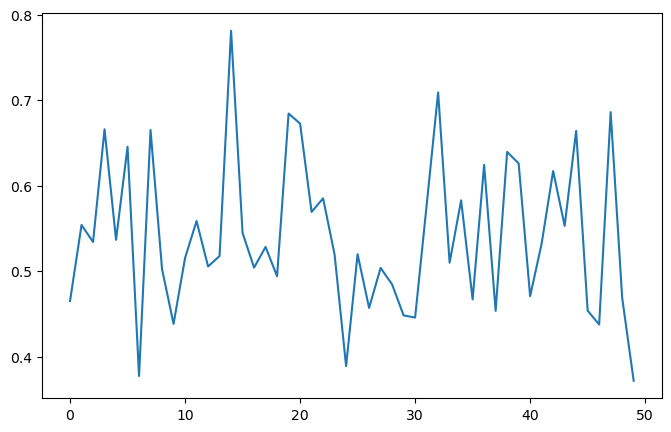

In [6]:
test_y = []

for y in range(50):
    res = Repeat2(False)
    print(res)
    test_y.append(res)

average = np.average(test_y)
print("Average R2:", average)

f = plt.figure(figsize=(8,5))
plt.plot(test_y)
plt.show()